In [1]:
import os
print(f'Current working dir: {os.getcwd()}')
from pathlib import Path
import torch
from torch.utils.data import TensorDataset, DataLoader

import pyro
import gpytorch

import pandas as pd
import matplotlib.pyplot as plt

from factorio.models.gp_approx_multi_taskpl import MultitaskApproxGPpl, fit
from factorio.utils.data_prep import make_gpnarx_regressor

import numpy as np

%matplotlib widget

Current working dir: c:\GitRepos\python-libraries


c:\GitRepos\python-libraries\.venv\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Data z 9. 1. 2022

In [2]:
dataroot = Path('N:\Datasets\TimeSeries\data_sources\pece-potraviny-j4\mereni220109')
filenames = [   
    'UI_001 2022-01-09 12.25.26.713.csv',
    'UI_002 2022-01-09 12.45.27.014.csv',
    'UI_003 2022-01-09 13.05.27.313.csv',
    'UI_004 2022-01-09 17.35.27.713.csv',
    'UI_005 2022-01-09 17.55.28.113.csv',
]
time_origins = [
    pd.to_datetime('09.01.2022 12:05:31 912', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 12:25:27 113', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 12:45:27 413', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 17:15:31 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('09.01.2022 17:35:28 213', format='%d.%m.%Y %H:%M:%S %f', utc=True),
]

### Data z 16. 1. 2022

In [3]:
dataroot = Path('N:\Datasets\TimeSeries\data_sources\pece-potraviny-j4\mereni220116')
# dataroot = Path('D:\DATA_FAST\pece-potraviny-j4\mereni220116')
filenames = [
    'UI_004 2022-01-16 17.12.09.113.csv',
    'UI_001 2022-01-16 13.08.47.913.csv',
    'UI_002 2022-01-16 14.12.08.214.csv',
    'UI_003 2022-01-16 16.12.08.614.csv',
]
time_origins = [
    pd.to_datetime('16.01.2022 16:12:11 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('16.01.2022 12:08:51 912', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('16.01.2022 13:12:11 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('16.01.2022 15:12:11 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
]

### Data z 24. 1. 2022

In [4]:
dataroot = Path('N:\Datasets\TimeSeries\data_sources\pece-potraviny-j4\mereni220124')
# dataroot = Path('D:\DATA_FAST\pece-potraviny-j4\mereni220116')
filenames = [
    'UIZ1_001 2022-01-23 13.42.03.913.csv',
    'UIZ2_001 2022-01-20 11.38.51.413.csv',
    'UIZ2_002 2022-01-23 13.45.31.713.csv',
]
time_origins = [
    pd.to_datetime('23.01.2022 12:12:11 912', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('20.01.2022 10:08:51 913', format='%d.%m.%Y %H:%M:%S %f', utc=True),
    pd.to_datetime('23.01.2022 12:15:31 912', format='%d.%m.%Y %H:%M:%S %f', utc=True),
]

In [5]:
tag_map = {
    'Sample': 'Sample',
    'X(ms)': 'Time [ms]',
    'doughInProofer[%MB99]':    'doughInProofer [%]',
    'DB_analog_convertor.temp_zone[0].AWGoutInt':   'Temperature measured [C]',
    'DB_Data_source_HMI_S7.HMI.temp_Z01':   'Temperature set [C]',
    'DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[0]':  'Bottom heater binary',
    'DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[1]':  'Top heater binary',
    'DB_product_position.zone[0].AVG':  'doughInProofer smoothed',
    'DB_Electrical_heaters_REQ1.zone_power[0, 0]':  'Bottom heater cont',
    'DB_Electrical_heaters_REQ1.zone_power[1, 0]':  'Top heater cont',
    'IEC_Timer_Brumuddal_Kotlever_delay.IN':    'Product at input binary',
    'DB_productPositionBrumuddal.zone[0].AVG':   'Occupancy average'
}


In [6]:
dfs = [
    pd.read_csv(dataroot/filename)  #, header=0, names=tag_map.values())
    for filename in filenames
]

df = dfs[0]

### Check consistency

In [7]:
correspondence = zip(dfs[0].columns, tag_map.values())

for i, col in enumerate(correspondence):
    print(f'{i}:{col}')

0:('Sample', 'Sample')
1:('X(ms) [23.01.2022 12:12:11 912 UTC]', 'Time [ms]')
2:('doughInProofer[%MB99]', 'doughInProofer [%]')
3:('DB_analog_convertor.temp_zone[0].AWGoutReal', 'Temperature measured [C]')
4:('DB_Data_source_HMI_S7.HMI.temp_Z01', 'Temperature set [C]')
5:('DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[0]', 'Bottom heater binary')
6:('DB_IO.O_HMI.zons[0].OUT_EL_Stykac_EN[1]', 'Top heater binary')
7:('DB_product_position.zone[0].AVG', 'doughInProofer smoothed')
8:('DB_Electrical_heaters_REQ1.zone_power[0; 0]', 'Bottom heater cont')
9:('DB_Electrical_heaters_REQ1.zone_power[1; 0]', 'Top heater cont')
10:('IEC_Timer_Brumuddal_Kotlever_delay.IN', 'Product at input binary')
11:('DB_productPositionBrumuddal.zone[0].AVG', 'Occupancy average')


In [17]:
for df in dfs:
    df.columns = tag_map.values()


output_seqs = torch.stack([
    torch.tensor(df['Temperature measured [C]'].to_numpy())
    for df in dfs
]).unsqueeze(-1)

input_seqs = torch.stack([
    torch.tensor(df[['Bottom heater binary',
       'Top heater binary',
       'Bottom heater cont',
       'Top heater cont',
       'Occupancy average']].to_numpy())
    for df in dfs
])

print(f'Outputs are of shape {output_seqs.shape}')
print(f'Inputs are of shape {input_seqs.shape}')

y_lag=1
u_lag=1
y_pred_horizont=1

Outputs are of shape torch.Size([3, 540, 1])
Inputs are of shape torch.Size([3, 540, 5])


In [18]:
setpoint = dfs[0]['Temperature set [C]'].iloc[0]

Y_tens = (output_seqs[0]-setpoint)/5.

X_tens = input_seqs[0]
X_tens[:, 2] = input_seqs[0][:, 2]/100.
X_tens[:, 3] = input_seqs[0][:, 3]/100.

Data z `doughInProofer smoothed` jsou zpožděná o cca 15 min. Vyšetříme korelaci pro časové zpoždění v daném rozsahu počtu samplů 70 - 90.

Pracovní bod pro teplotu jsme zafixovali - odečte se od dat před samotným fitováním.

regressor.shape: torch.Size([529, 6])
y_regressor.shape: torch.Size([529, 1])


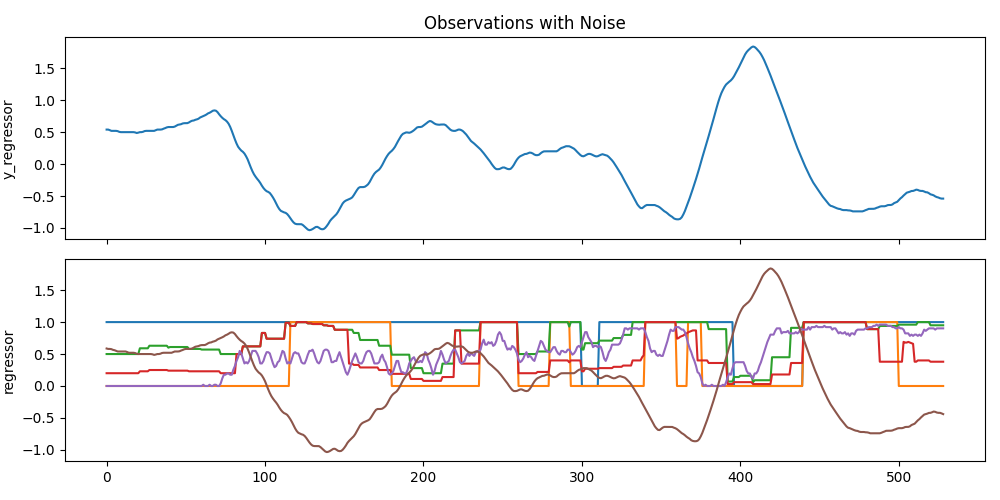

In [19]:
additional_delay = 10
regressor, y_regressor = make_gpnarx_regressor(X_tens.float(), Y_tens.float(), y_lag=y_lag, u_lag=u_lag, y_pred_horizont=y_pred_horizont)
y_regressor = y_regressor[additional_delay:, :]
regressor = regressor[:-additional_delay, :]

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].plot(y_regressor)
ax[0].set_ylabel('y_regressor')
ax[1].plot(regressor)
ax[1].set_ylabel('regressor')
ax[0].set_title('Observations with Noise')
fig.tight_layout()

print(f'regressor.shape: {regressor.shape}')
print(f'y_regressor.shape: {y_regressor.shape}')

In [20]:
num_inducing=32
num_iter = 100
lr = 0.05
patience = 50
use_predictive_mll = False
learn_inducing_locations = True

num_tasks = Y_tens.size(-1)  # must be the size in the second dimension of data
num_latents = 5  # can be arbitrary number

model = MultitaskApproxGPpl(
    obs_dim=y_regressor.size(-1),
    num_latents=num_latents,
    input_dim=regressor.size(-1),
    num_inducing=num_inducing,
    inputs_range=None,
    learn_inducing_locations=learn_inducing_locations,
    subsample_size=1,
    lr=lr,
    use_predictive_mll=use_predictive_mll
)

loader = DataLoader(
    TensorDataset(
        regressor,
        y_regressor
    ),
    batch_size=256,
    shuffle=True
)
final_model_path = fit(model,
    train_dataloader=loader,
    max_epochs=num_iter,
    patience=patience,
    verbose=False,
    checkpoint_path='final_model.ckpt')


c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type              | Params
-------------------------------------------
0 | gp   | MultitaskApproxGP | 6.3 K 
1 | mll  | VariationalELBO   | 6.3 K 
-------------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)
c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value

Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 17.24it/s, loss=0.0547, v_num=286, train_loss=0.0234]  


c:\GitRepos\python-libraries\.venv\lib\site-packages\pytorch_lightning\core\saving.py:212: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['mll.likelihood.raw_task_noises', 'mll.likelihood.raw_noise', 'mll.likelihood.raw_task_noises_constraint.lower_bound', 'mll.likelihood.raw_task_noises_constraint.upper_bound', 'mll.likelihood.raw_noise_constraint.lower_bound', 'mll.likelihood.raw_noise_constraint.upper_bound', 'mll.model.variational_strategy.lmc_coefficients', 'mll.model.variational_strategy.base_variational_strategy.inducing_points', 'mll.model.variational_strategy.base_variational_strategy.variational_params_initialized', 'mll.model.variational_strategy.base_variational_strategy.updated_strategy', 'mll.model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean', 'mll.model.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar', 'mll.model.mean_module.constant', 'mll.

torch.Size([525, 1])


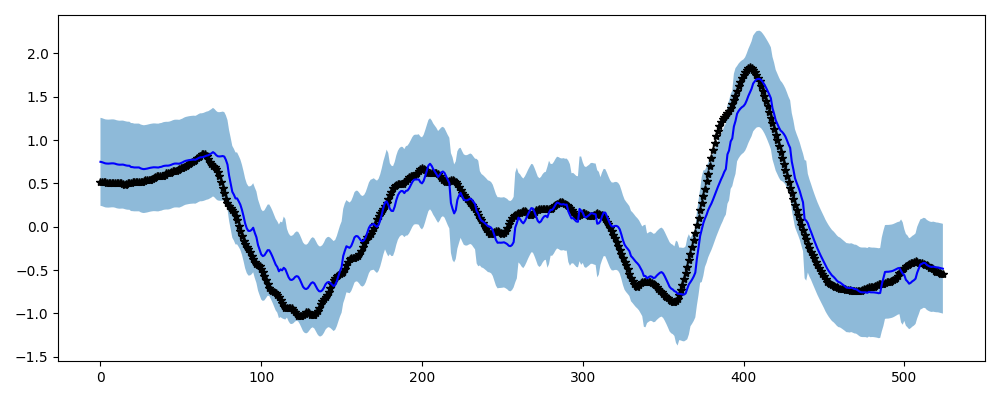

In [12]:
model_reloaded = MultitaskApproxGPpl.load_from_checkpoint(final_model_path, strict=False)

model_reloaded.eval()
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model_reloaded.predict(regressor)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

print(lower.shape)

# Initialize plots
time_aux = torch.arange(mean.size(0))
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Plot training data as black stars
ax.plot(time_aux, y_regressor, 'k*')
# Predictive mean as blue line
ax.plot(time_aux, mean.numpy(), 'b')
# # Shade in confidence
ax.fill_between(time_aux, lower.squeeze(), upper.squeeze(), alpha=0.5)
# # ax.set_ylim([-3, 3])
# ax.legend(['Data', 'Mean', '$\pm\sigma$'])

fig.tight_layout()

torch.Size([525, 1])


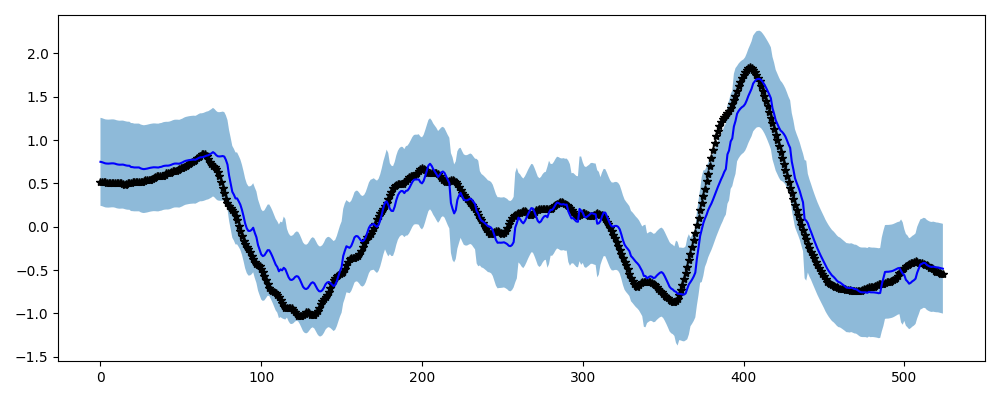

In [13]:
model.eval()
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model.predict(regressor)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

print(lower.shape)

# Initialize plots
time_aux = torch.arange(mean.size(0))
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Plot training data as black stars
ax.plot(time_aux, y_regressor, 'k*')
# Predictive mean as blue line
ax.plot(time_aux, mean.numpy(), 'b')
# # Shade in confidence
ax.fill_between(time_aux, lower.squeeze(), upper.squeeze(), alpha=0.5)
# # ax.set_ylim([-3, 3])
# ax.legend(['Data', 'Mean', '$\pm\sigma$'])

fig.tight_layout()

## Tests on Held-out data

Temperature set [C] = 235
regressor_test.shape: torch.Size([525, 20])
y_regressor_test.shape: torch.Size([525, 1])


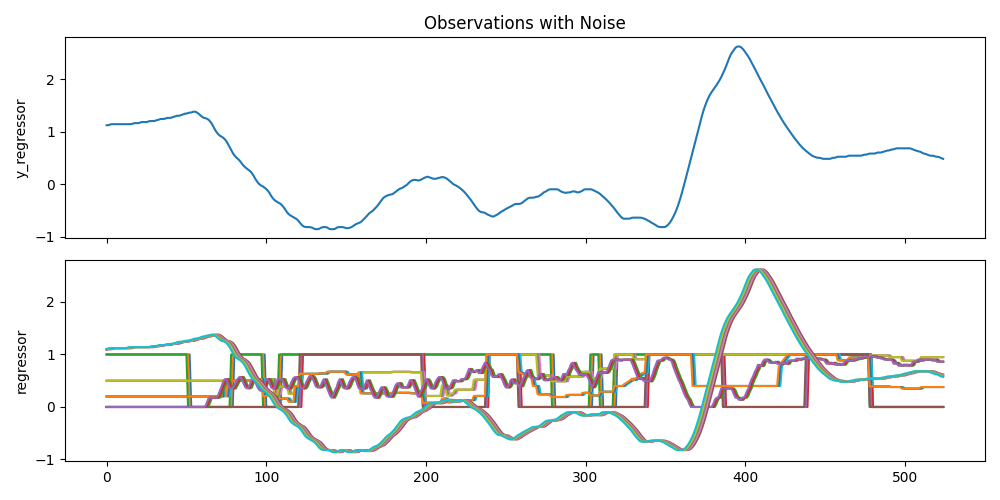

In [14]:
test_idx=2
setpoint = dfs[test_idx]['Temperature set [C]'].iloc[0]
print(f'Temperature set [C] = {setpoint}')

Y_tens_test = (output_seqs[test_idx]-setpoint)/5.

X_tens_test = input_seqs[test_idx]
X_tens_test[:, 2] = input_seqs[test_idx][:, 2]/100.
X_tens_test[:, 3] = input_seqs[test_idx][:, 3]/100.

regressor_test, y_regressor_test = make_gpnarx_regressor(X_tens_test.float(), Y_tens_test.float(), y_lag=y_lag, u_lag=u_lag, y_pred_horizont=y_pred_horizont)
y_regressor_test = y_regressor_test[additional_delay:, :]
regressor_test = regressor_test[:-additional_delay, :]

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].plot(y_regressor_test)
ax[0].set_ylabel('y_regressor')
ax[1].plot(regressor_test)
ax[1].set_ylabel('regressor')
ax[0].set_title('Observations with Noise')
fig.tight_layout()

print(f'regressor_test.shape: {regressor_test.shape}')
print(f'y_regressor_test.shape: {y_regressor_test.shape}')

torch.Size([525, 1])


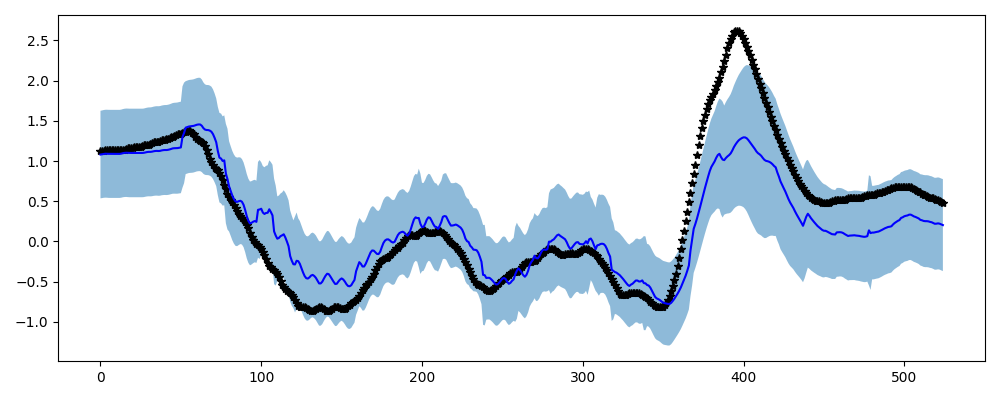

In [15]:
model.eval()
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model.predict(regressor_test)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

print(lower.shape)

# Initialize plots
time_aux = torch.arange(mean.size(0))
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Plot training data as black stars
ax.plot(time_aux, y_regressor_test, 'k*')
# Predictive mean as blue line
ax.plot(time_aux, mean.numpy(), 'b')
# # Shade in confidence
ax.fill_between(time_aux, lower.squeeze(), upper.squeeze(), alpha=0.5)
# # ax.set_ylim([-3, 3])
# ax.legend(['Data', 'Mean', '$\pm\sigma$'])

fig.tight_layout()

Precision of temperature sensor is visibly 1 degree of Celsius. This needs to be interpolated and smoothed.

### Fit model on data
Protože máme pro trénování k dispozici data zpožděná o 15 minut, zahazujeme prvních 15 dat a fitujeme pouze na datech s akčními zásahy bez zpoždění.

In [16]:
example_idx = 3

fn_crosscorr = lambda a, b, lag: a.corr(b.shift(lag))
lag_range = np.arange(80, 90)
xcov_sliding = [
    fn_crosscorr(dfs[example_idx]['Occupancy average'],
              dfs[example_idx]['doughInProofer smoothed'], lag=i)
    for i in lag_range
]

best_lag = lag_range[np.argmax(xcov_sliding)]
print(f'Best lag: {best_lag}')

fig, ax = plt.subplots(2, 1, figsize=(10, 4))
dfs[example_idx]['doughInProofer smoothed lagged'] = dfs[example_idx]['doughInProofer smoothed'].shift(best_lag)
# dfs[example_idx]['doughInProofer [%] lagged'] = dfs[example_idx]['doughInProofer [%]'].shift(best_lag)/100.
cols_to_plot = set(dfs[example_idx].columns) - {'Sample',
            # 'Time [ms]',
            'Bottom heater cont',
            'Bottom heater binary', 
            'Top heater cont',
            'Top heater binary',
            'Temperature set [C]',
            'Temperature measured [C]',
            'Product at input binary',
            'doughInProofer [%]',
            'doughInProofer smoothed'
            }
dfs[example_idx][cols_to_plot].plot(x='Time [ms]', ax=ax[0])
ax[1].plot(lag_range, xcov_sliding, label='lagged cross-correlation')
ax[1].legend()
ax[1].set_xlabel('Sample lag')
ax[1].set_ylabel('Cross-correlation')
fig.tight_layout()

dfs[example_idx][cols_to_plot-{'Time [ms]'}].corr()


IndexError: list index out of range